In [1]:
%matplotlib inline

# Imports
import copy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *




:0: FutureWarning: IPython widgets are experimental and may change in the future.


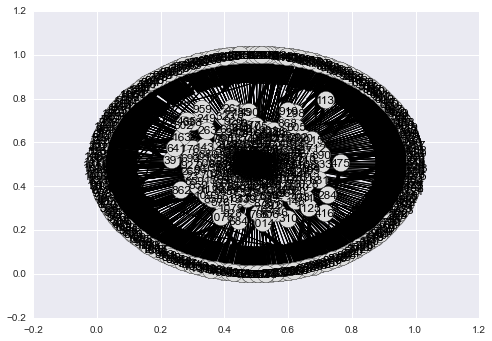

In [5]:
# Initialize Space
g=nx.read_weighted_edgelist("2010citytocity.csv",nodetype=str,delimiter=',')
g=nx.convert_node_labels_to_integers(g,label_attribute='old_label')
g=g.to_directed()

# Draw Space
g_layout = nx.spring_layout(g, iterations=100)
#nx.draw_networkx(g, pos=flights_layout, node_color='#dddddd')

In [48]:
# Initialize Space
g=nx.read_weighted_edgelist("2010citytocity_monthly.csv",nodetype=str,delimiter=',')
g=nx.convert_node_labels_to_integers(g,label_attribute='old_label')
g=g.to_directed()


# Pick a city to infect initially
initial_infected = [1,100,250] #np.random.choice(g.nodes())
#print(initial_infected)
# Setup initial S/I/R states
for node_id in g.nodes():
    if node_id in initial_infected:
        g.node[node_id]['infected']=1000 #int(np.random.normal(mu,sigma/100))
        g.node[node_id]["state"] = "I"
        print(g.node[node_id])
    else:
        g.node[node_id]['infected']=0
        g.node[node_id]["state"] = "S"

# Probability of infection per edge
reproduction_number=.85
#transmission_rate = 0.2
effective_contacts=15 #reproduction_number/transmission_rate
#reproduction_number=effective_contacts*transmission_rate
transmission_rate=reproduction_number/effective_contacts
print('R0={0} and B={1}'.format(reproduction_number,transmission_rate))
passengers_per_flight=150
prob_of_flying=.05
#print('check',g.node[0]['infected'])


# Track graph history
g_history = [copy.deepcopy(g)]

# Now run the model 
max_steps = 50
for step in xrange(max_steps):
    # Store changes
    num_infected=0
    for n in g.nodes():
        num_infected+=g.node[n]['infected']
    g_step=g
    print('Step {0} has {1} infected people in {2} cities'.format(step,num_infected,num_hosts_infected))
    
    # Iterate over I and infect any S neighbors
    for node_id in g.nodes():
        if g.node[node_id]["state"] == "I":
            #print('ID',node_id)
            #print('Infected at node',g.node[node_id]['infected'])
            
            # Decide how many infected are traveling
            infected_traveling=np.random.binomial(g.node[node_id]['infected'],prob_of_flying)
                
            if infected_traveling>g.node[node_id]['infected']:
                infected_traveling=g.node[node_id]['infected']
            #print('infected_traveling',infected_traveling)
            
            # Get travel options
            neighbors = g.neighbors(node_id)
            #print('neighbors',neighbors)
            passenger_list=[]
            for neighbor_id in neighbors:
                passenger_list.append(g.edge[node_id][neighbor_id]['weight'])
            
            #print('passenger_list',passenger_list)
            # Create passenger distribution
            percent_list = [float(i)/sum(passenger_list) for i in passenger_list]

            #passenger_dist=np.cumsum(percent_list)
            #print('passenger_dist',percent_list)
            
            # Create travel distribution
            travel_dist=np.random.multinomial(infected_traveling, percent_list)
            #print('travel_dist',travel_dist)
            
            # Convert number of travels to infection
            infected_travelers=[]
            for i in xrange(len(travel_dist)):
                moving_passengers=travel_dist[i]
                max_passengers=g.edge[node_id][neighbors[i]]['weight']
                moving_passengers*=transmission_rate*passengers_per_flight
                moving_passengers=int(moving_passengers)
                if moving_passengers>max_passengers:
                    moving_passengers=max_passengers
                
                    
                infected_travelers.append(moving_passengers)
            
            # Node update
            for i in xrange(len(neighbors)):
                neighbor_id=neighbors[i]
                #print('Infected at neighbor',neighbor_id,g.node[neighbor_id]['infected'], 'Recieving', infected_travelers[i])
                
                # Move Infected
                num_infected_at_neighbor=g.node[neighbor_id]['infected']
                g_step.node[neighbor_id]['infected']=num_infected_at_neighbor+infected_travelers[i]
                g_step.node[node_id]['infected']=g.node[node_id]['infected']-infected_travelers[i]
            
                # Calculate in host spread
                new_infected=int(g.node[node_id]['infected']*reproduction_number)

                # Calculate in host death
                removed_infected=g.node[node_id]['infected']

                # Sum new infection change
                new_infected_total=int(max(g.node[node_id]['infected']+new_infected-removed_infected,0))
                g_step.node[node_id]['infected']=int(new_infected_total)
                
                
                                                            
            
    
    # Update graph
    num_hosts_infected=0
    for node_id in g_step.nodes():
        if g_step.node[node_id]['infected']>0:
            g_step.node[node_id]["state"] = "I"
            num_hosts_infected+=1
        else:
            g_step.node[node_id]["state"] = "S"
                                       
    # Resolve g_step to g
    g=g_step
                                       
    # Track the latest step
    g_history.append(copy.deepcopy(g))
    
    # End if no infections
    if num_hosts_infected==0:
        print('No Disease')
        break
        
#display_graph_step()
#interact(display_graph_step,step=IntSliderWidget(min=0, max=len(g_history)-1,step=1))
#print('R0',reproduction_number)

{'state': 'I', 'infected': 1000, 'old_label': 'Bucaramanga:Colombia'}
{'state': 'I', 'infected': 1000, 'old_label': 'Newquay:United Kingdom'}
{'state': 'I', 'infected': 1000, 'old_label': 'Fort Wayne:IN'}
R0=0.85 and B=0.0566666666667
Step 0 has 3000 infected people in 0 cities
Step 1 has 2053.0 infected people in 11 cities
Step 2 has 1308.0 infected people in 27 cities
Step 3 has 933.0 infected people in 17 cities
Step 4 has 642.0 infected people in 11 cities
Step 5 has 497.0 infected people in 10 cities
Step 6 has 372.0 infected people in 8 cities
Step 7 has 277.0 infected people in 5 cities
Step 8 has 191 infected people in 3 cities
Step 9 has 152.0 infected people in 2 cities
Step 10 has 120 infected people in 3 cities
Step 11 has 116 infected people in 5 cities
Step 12 has 81 infected people in 6 cities
Step 13 has 53 infected people in 4 cities
Step 14 has 41 infected people in 4 cities
Step 15 has 28.0 infected people in 2 cities
Step 16 has 28 infected people in 3 cities
Step 1